# 🌍 Coupling in SpeedyWeather

### Notebook originally created by P.L. Vidale. Text edited by A. Denvil-Sommer.

In modern modelling, the lines between weather prediction models and climate models are increasingly blurred — both rely on similar physical principles and components. The main differences lie in resolution, ensemble size, and timescale of interest.

In this session, we will:

- 💡 Explore how to couple Earth system components:

   * 🏞️ Land (e.g. soil temperature and moisture)

   * 🌊 Ocean (e.g. sea surface temperature and heat fluxes)

- 🧪 Design and run your own experiment, just like in a research project.

🧭 Objectives
You are encouraged to:

1. Think of a science question.

2. Design a modelling setup that helps answer that question.

3. Run a simulation and analyse the output — using diagnostics or NetCDF tools (e.g. CDO, ncvis).

As a starting point, we suggest using the `PrimitiveWetModel`, which includes physics like **humidity** and **precipitation**. But feel free to explore others, like `ShallowWaterModel` or `PrimitiveDryModel`.

## 🔁 Coupled Models in Practice
In real climate models like CESM, HadGEM or EC-Earth, coupling means linking atmospheric, oceanic, land, and sometimes ice components together.

Similarly, in SpeedyWeather.jl, coupling land and ocean components lets you study:

- Effects of albedo changes

- Impact of soil moisture feedback

- Response to prescribed sea surface temperatures

This coupling is simple but mirrors the modular architecture used in Earth system models.

## 🛠️ Tips for Designing Your Own Experiment
- Start by creating a grid and setting up the components.
- Then create the model.
- If you want to simulate climate, consider:

  * Running for multiple years

  * Analysing seasonal averages

  * Saving output to NetCDF for post-processing
 
📊 Want to visualise or compare runs? Use `CairoMakie`, or export to `.nc` and use `ncvis` or `CDO`.

The list of currently available Earth System modeuls is here: [Parameterizations](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/parameterizations/).

## 🌍 Setting Up a Realistic Planet

Let's configure a planet with a realistic **land–sea mask** and **orography** (surface topography). We'll begin with a moderate spectral resolution of T31, which is suitable for fast experimentation. The goal is to extend the simulation to one year, taking our setup a step closer to a climate modelling scenario, where longer-term atmospheric behavior can emerge.

In [1]:
#using Pkg; Pkg.instantiate(); Pkg.precompile()
#using Pkg; Pkg.add("SpeedyWeather")

☝️ Remember: if you want to save your output in specific directory you can identify it like this:

`output = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="Your_path", id="Climate", output_dt=Minute(180))`

In [2]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, output=output)
simulation = initialize!(model)
#run!(simulation, period=Day(365), output=true)
run!(simulation, period=Day(30), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate 100%|██████| Time: 0:00:08 (843.54 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [3]:
model.land

LandModel <: SpeedyWeather.AbstractWetLand
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}
├ geometry: LandGeometry{Float32, Vector{Float32}}
├ thermodynamics: LandThermodynamics{Float32}
├ temperature: SeasonalLandTemperature{Float32, Field{Float32, 2, Matrix{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ soil_moisture: SeasonalSoilMoisture{Float32, OctahedralGaussianField{Float32, 3, Array{Float32, 3}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ vegetation: VegetationClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWea

In [4]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_clim=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_clim, title="Large-scale precipiation [mm]: Accumulated over NN days", colorrange = (0,250), colormap=:dense)
save("Clim_precip.png",fig)

In [5]:
#simulation
#simulation.model.geometry
simulation.model
simulation.model.orography.orography
#simulation.prognostic_variables
#simulation.diagnostic_variables
#simulation.diagnostic_variables.dynamics
#simulation.diagnostic_variables.physics
#simulation.diagnostic_variables.grid

3168-element, 48-ring OctahedralGaussianField{Float32, 1} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}:
   14.983424
   -5.667698
  -16.814646
  -20.29903
  -20.024845
  -18.689304
  -17.529533
  -17.382645
  -19.136171
  -23.095566
  -28.06001
  -31.17983
  -28.984755
    ⋮
 2456.6387
 2227.3223
 2038.6853
 1918.419
 1867.0206
 1860.9578
 1871.1128
 1883.6133
 1908.3062
 1969.998
 2089.5295
 2267.4888

## 💧 Exploring Surface Fluxes from Earth System Components

We now begin experimenting with surface fluxes from land component. As a first step, let's compare the behavior of dry land versus wet land conditions.

To support this analysis, it's helpful to include surface fluxes in the model output. You may also want to enable the full suite of land surface diagnostics for a more complete picture.

📌 To see what's available, explore the diagnostic groups under `DiagnosticVariables`, such as: `SpeedyWeather.EvaporativeFluxOutput`.
This will help you monitor key variables like **evaporation**, **sensible heat flux**, and more.

In [6]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_Dry-Land", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
#surface_evaporation = NoSurfaceEvaporation(spectral_grid)
thermodynamics = LandThermodynamics(spectral_grid, heat_conductivity=0.25)
land = DryLandModel(spectral_grid; thermodynamics)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, land, output=output)
simulation = initialize!(model)
run!(simulation, period=Day(365), output=true)
#run!(simulation, period=Day(30), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate_Dry-Land 100% Time: 0:01:37 (884.82 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [7]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_no_land=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_no_land, title="Large-scale precipiation [mm]: Dry Land Accumulated over NN days", colorrange = (0,250), colormap=:dense)
#fig=contour!(orography.orography)
#oro=orography.orography
#fig=heatmap(oro, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("DryLand_precip.png",fig)

In [8]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_WetLand", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
#surface_evaporation = NoSurfaceEvaporation(spectral_grid)
thermodynamics = LandThermodynamics(spectral_grid, heat_conductivity=0.25)
land = LandModel(spectral_grid; thermodynamics)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, land, output=output)
simulation = initialize!(model)
run!(simulation, period=Day(365), output=true)
#run!(simulation, period=Day(30), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate_WetLand 100% Time: 0:01:42 (844.47 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [9]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_land=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_land, title="Large-scale precipiation [mm]: Wet Land Accumulated over NN days", colorrange = (0,250), colormap=:dense)
#fig=contour!(orography.orography)
#oro=orography.orography
#fig=heatmap(oro, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("WetLand_precip.png",fig)

In [10]:
model.land

LandModel <: SpeedyWeather.AbstractWetLand
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}
├ geometry: LandGeometry{Float32, Vector{Float32}}
├ thermodynamics: LandThermodynamics{Float32}
├ temperature: SeasonalLandTemperature{Float32, Field{Float32, 2, Matrix{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ soil_moisture: SeasonalSoilMoisture{Float32, OctahedralGaussianField{Float32, 3, Array{Float32, 3}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ vegetation: VegetationClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWea

`subtypes()` function can be used to list which types inherit from a given abstract type. This is very useful for understanding what model components are available to plug into a simulation.

In [11]:
subtypes(SpeedyWeather.AbstractLand)

2-element Vector{Any}:
 SpeedyWeather.AbstractDryLand
 SpeedyWeather.AbstractWetLand

✅ `subtypes(SpeedyWeather.AbstractLand)`
This tells you which types of land models are available in SpeedyWeather:

- `SpeedyWeather.AbstractDryLand` – a land model without evaporation (no latent heat flux).

- `SpeedyWeather.AbstractWetLand` – a land model with moisture exchange (i.e., supports evaporation and soil moisture processes).

These aren’t directly usable themselves, but the models you use will inherit from one of these (like LandModel, which is a wet land).

In [12]:
subtypes(SpeedyWeather.AbstractLandTemperature)

3-element Vector{Any}:
 ConstantLandTemperature
 LandBucketTemperature
 SeasonalLandTemperature

✅ `subtypes(SpeedyWeather.AbstractLandTemperature)`
These are the options for modeling land temperature:

- `ConstantLandTemperature` – sets the land surface temperature to a fixed value.

- `LandBucketTemperature` – uses a simple one- or two-layer bucket model to simulate evolving soil temperature.

- `SeasonalLandTemperature` – varies land temperature in time with a seasonal cycle.

In [13]:
subtypes(SpeedyWeather.AbstractSoilMoisture)

3-element Vector{Any}:
 LandBucketMoisture
 NoSoilMoisture
 SeasonalSoilMoisture

✅ `subtypes(SpeedyWeather.AbstractSoilMoisture)`
These are the available soil moisture schemes:

- `LandBucketMoisture` – a bucket model where soil moisture evolves due to rainfall and evaporation.

- `NoSoilMoisture` – disables soil moisture completely (e.g., for idealized experiments).

- `SeasonalSoilMoisture` – prescribes a repeating seasonal moisture cycle.

## 🏞️ Coupling with a Dynamic Land Model (Bucket Scheme)
Up to this point, we’ve used a **prescribed seasonal land climatology**, meaning the land surface conditions were fixed or followed a repeating pattern.

Now, we’ll take a more interactive approach by coupling the model with a **bucket land scheme**, allowing the **land surface temperature** and **soil moisture** to evolve over time. This enables the land to exchange **heat** and **moisture fluxes** with the atmosphere, making the simulation more realistic and responsive to weather events.

In [14]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_Bucket", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
#surface_evaporation = NoSurfaceEvaporation(spectral_grid)
thermodynamics = LandThermodynamics(spectral_grid, heat_conductivity=0.25)
temperature=LandBucketTemperature(spectral_grid)
soil_moisture=LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, land, output=output)
simulation = initialize!(model)
run!(simulation, period=Day(365), output=true)
#run!(simulation, period=Day(30), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate_Bucket  97%  ETA: 0:00:03 (876.07 years/day)┌ Warning: NaN or Inf detected at time step 11349
└ @ SpeedyWeather ~/.julia/packages/SpeedyWeather/iLz8G/src/output/feedback.jl:144
Weather is speedy: run Climate_Bucket 100% Time: 0:01:36 (897.40 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [15]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_land=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_land, title="Large-scale precipiation [mm]: Bucket Land Accumulated over NN days", colorrange = (0,250), colormap=:dense)
#fig=contour!(orography.orography)
#oro=orography.orography
#fig=heatmap(oro, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("BucketLand_precip.png",fig)

In [16]:
subtypes(SpeedyWeather.AbstractOcean)

4-element Vector{Any}:
 AquaPlanet
 ConstantOceanClimatology
 SeasonalOceanClimatology
 SlabOcean

## 🌊 Coupling with a Slab Ocean Model
Until now, we’ve been using a prescribed seasonal ocean climatology, meaning sea surface temperatures followed a fixed seasonal cycle.

Now, we’ll couple the model with a **slab ocean**, a simplified representation of a shallow mixed-layer ocean that can respond dynamically to atmospheric conditions. This allows the ocean to exchange heat with the atmosphere and evolve over time, enabling more realistic feedbacks in the climate system.

In [17]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel,  id="Climate_Ocean", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
#surface_evaporation = NoSurfaceEvaporation(spectral_grid)
thermodynamics = LandThermodynamics(spectral_grid, heat_conductivity=0.25)
temperature=LandBucketTemperature(spectral_grid)
soil_moisture=LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid)
# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, land, ocean, output=output)
simulation = initialize!(model)
run!(simulation, period=Day(365), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate_Ocean  94%  ETA: 0:00:06 (835.77 years/day)┌ Warning: NaN or Inf detected at time step 10989
└ @ SpeedyWeather ~/.julia/packages/SpeedyWeather/iLz8G/src/output/feedback.jl:144
Weather is speedy: run Climate_Ocean 100% Time: 0:01:38 (879.59 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [18]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_land_ocean=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_land_ocean, title="Large-scale precipiation [mm]: Slab Ocean and Bucket Land Accumulated over NN days", colorrange = (0,250), colormap=:dense)
#fig=contour!(orography.orography)
#oro=orography.orography
#fig=heatmap(oro, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("Ocean-BucketLand_precip.png",fig)

## 🧪 Exploring Surface Flux Denial: What Drives Atmospheric Evolution?
This section presents a series of experiments designed to help you understand the role of different surface fluxes — such as heat, moisture, and momentum — in shaping atmospheric behavior.

By selectively turning fluxes on or off, you can begin to identify which components drive specific features of the simulation.

⚠️ Note: These experiments require careful attention to what each surface flux option is doing. Dive in, explore, and observe — but be prepared for unexpected results!

In [19]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_No-Ocean-Evap", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip
add!(output,SpeedyWeather.EvaporativeFluxOutput())

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
surface_evaporation = NoSurfaceEvaporation(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, surface_evaporation, output=output)
simulation = initialize!(model)
#run!(simulation, period=Day(360), output=true)
run!(simulation, period=Day(10), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run Climate_No-Ocean-Evap 100% Time: 0:00:02 (939.18 years/day)m


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [20]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_no_evap=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_no_evap, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
#fig=contour!(orography.orography)
#oro=orography.orography
#fig=heatmap(oro, title="Large-scale precipiation [mm]: No Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("NoEvap_precip.png",fig)

In [21]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_No-Ocean-Evap", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip
add!(output,SpeedyWeather.SurfaceFluxesOutput()...)

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
surface_evaporation = SurfaceLandEvaporation(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, surface_evaporation, output=output)
simulation = initialize!(model)
#run!(simulation, period=Day(360), output=true)
run!(simulation, period=Day(10), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run 0001 100%|█████████| Time: 0:00:02 (880.39 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [22]:
using CairoMakie
(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
precip_large_scale_land_evap=precip_large_scale
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale_land_evap, title="Large-scale precipiation [mm]: Land Evap Accumulated over NN days", colorrange = (0,150), colormap=:dense)
save("LandEvap_precip.png",fig)

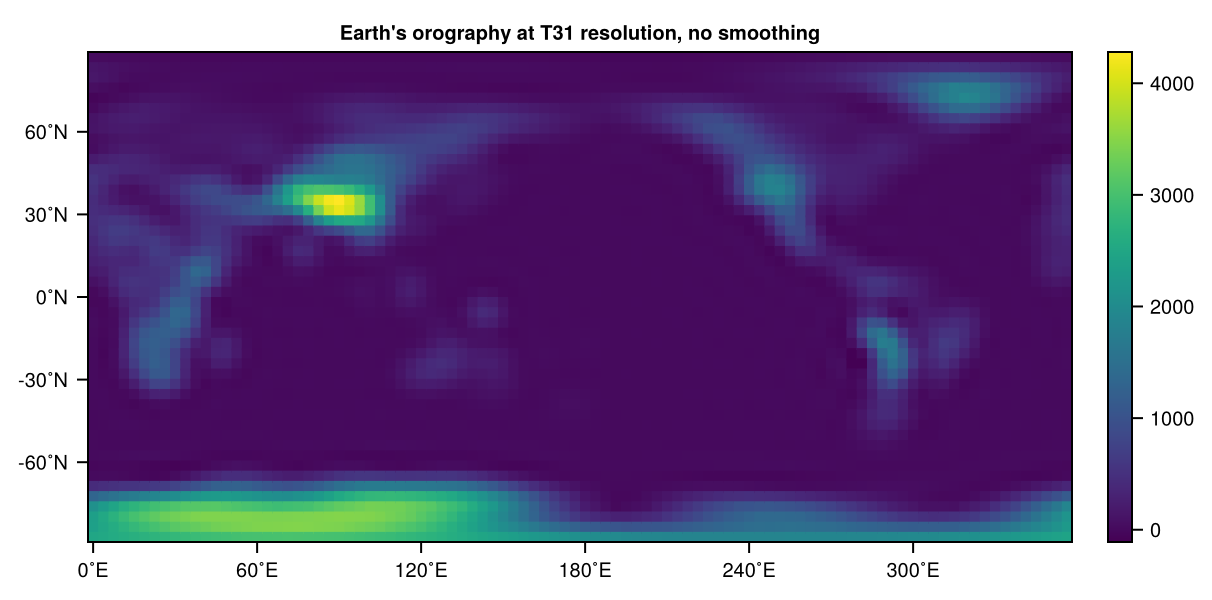

In [23]:
orography = EarthOrography(spectral_grid)
initialize!(orography, model)
heatmap(orography.orography, title="Earth's orography at T31 resolution, no smoothing")

In [24]:
using SpeedyWeather
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_No-Ocean-Evap", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip
add!(output,SpeedyWeather.SurfaceFluxesOutput()...)

# Some parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, output=output)
simulation = initialize!(model)
#run!(simulation, period=Day(360), output=true)
run!(simulation, period=Day(10), output=true)

[ Info: Time step changed from 2400000 to 2700000 milliseconds (+12%) to match output frequency.
Weather is speedy: run 0002 100%|█████████| Time: 0:00:02 (867.07 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

## Optional approaches

In [25]:
using NCDatasets
ds = NCDataset("/Users/vidale/SpeedyWeather/run_0014/output.nc")
prec=1000*ds["precip_cond"]
lat=ds["lat"]
lon=ds["lon"]

LoadError: NetCDF error: [31mOpening path /Users/vidale/SpeedyWeather/run_0014/output.nc: No such file or directory[39m (NetCDF error code: 2)